In [1]:
import matplotlib.pyplot as plt
import nest
import numpy as np

import os
import sys
    
from pynestml.frontend.pynestml_frontend import generate_nest_target
NEST_SIMULATOR_INSTALL_LOCATION = nest.ll_api.sli_func("statusdict/prefix ::")   
    
%matplotlib inline

<frozen importlib._bootstrap>:241: RuntimeWarning: compiletime version 3.8 of module 'pynestkernel' does not match runtime version 3.1
<frozen importlib._bootstrap>:241: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 880 from C header, got 888 from PyObject



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: master@61f08e0ea
 Built: Jul 14 2022 17:28:07

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
co_creation = 0
exc_edlif = 0
inh_edlif = 0

nest.ResetKernel()

if co_creation:
    # neuron and synapse co-created
    nest.Install("nestml_0_module")
    #exc_neuron_model_name = "edlif_percent_mwe0_nestml__with_stdp0_nestml" # "iaf_psc_alpha" "edlif_psc_percent"
    #inh_neuron_model_name = "edlif_percent_mwe0_nestml__with_stdp0_nestml"
    exc_neuron_model_name = "edlif_psc_alpha_percent0_nestml__with_stdp0_nestml"
    inh_neuron_model_name = "edlif_psc_alpha_percent0_nestml__with_stdp0_nestml"
    #synapses_model_name = "stdp0_nestml__with_edlif_percent_mwe0_nestml" # "stdp_synapse"
    synapses_model_name = "stdp0_nestml__with_edlif_psc_alpha_percent0_nestml"
    #synapses_model_name = "stdp_synapse"


else:
    # only neuron creates
    nest.Install("nestmlmodule")
    if exc_edlif:
        exc_neuron_model_name = "edlif_psc_exp_percent" # "iaf_psc_alpha" "edlif_psc_percent"
    else:
        exc_neuron_model_name = "iaf_psc_alpha"
    if inh_edlif:
        inh_neuron_model_name = "edlif_psc_alpha_percent" # "iaf_psc_alpha" "edlif_psc_percent"
    else:
        inh_neuron_model_name = "iaf_psc_alpha"
    synapses_model_name = "stdp_synapse"





Sep 07 18:46:24 Install [Info]: 
    loaded module nestmlmodule


In [3]:
# parameters
## simulation
simtime = 100
iterations = 1
seed = 4
dim = 2
exc_circular_conn = True
inh_circular_conn = True
if dim == 2:
    mask = "circular"
elif dim == 3:
    mask = "spherical"

## excitatory neurons
exc_neuron_type = exc_neuron_model_name
exc_positions = nest.spatial.free(
    nest.random.uniform(min=-0.5, max=0.5),  # using random positions in a uniform distribution
    num_dimensions=dim  # have to specify number of dimensions
    )
exc_n = 200
exc_ndict = {"I_e": 200.0, "tau_m": 20.0}

## inhibitory neurons
inh_neuron_type = inh_neuron_model_name
inh_positions = nest.spatial.free(
    nest.random.uniform(min=-0.5, max=0.5),  
    num_dimensions=dim)
inh_n = 100
inh_ndict = {"I_e": 200.0, "tau_m": 20.0}

## noise generatos
exc_noise_type = "poisson_generator"
inh_noise_type = "poisson_generator"
exc_rate = 80000  # rate in Hz
inh_rate  = 15000

## connettps://nest-simulator.rections
# hadthedocs.io/en/v3.3/tutorials/pynest_tutorial/part_4_spatially_structured_networks.html#pynest-tutorial-4
# https://nest-simulator.readthedocs.io/en/v3.3/guides/spatially_structured_networks.html#spatial-networks
### exc to inh
exc_d = 1.0
exc_synapse_model = synapses_model_name
print("1")
exc_inh_wr = nest.Create('weight_recorder')
nest.CopyModel(exc_synapse_model, "exc_synapse_rec", {"weight_recorder": exc_inh_wr})
exc_alpha_min = 0.1
exc_alpha_max = 2.
exc_alpha = nest.random.uniform(min=exc_alpha_min, max=exc_alpha_max)
exc_w_min = 0.5
exc_w_max = 5.
exc_w = nest.random.uniform(min=exc_w_min, max=exc_w_max)
Ke = 25
if exc_circular_conn:
    # Circular mask, distance-dependent connection probability with gaussian distribution
    print("exc: circular connection")
    exc_conn_dict = {'rule': 'pairwise_bernoulli',
             'p': nest.spatial_distributions.gaussian(nest.spatial.distance, std=0.2),
             'mask': {mask: {'radius': 0.35}},
             'allow_autapses': False,
             #'weight': exc_w
             }
else:
    print("exc: indegree connection")
    exc_conn_dict = {"rule": "fixed_indegree", "indegree": Ke}
    
exc_syn_dict = {"delay": exc_d, "weight": exc_w}
if not(exc_synapse_model==""):
    exc_syn_dict["synapse_model"] = "exc_synapse_rec"
    if not(exc_circular_conn):
        exc_syn_dict["alpha"] = exc_alpha

### inh to exc
inh_d = 1.0
# delays could be space-dependent
inh_synapse_model = synapses_model_name
print("5")
inh_exc_wr = nest.Create('weight_recorder')
nest.CopyModel(inh_synapse_model, "inh_synapse_rec", {"weight_recorder": inh_exc_wr})
inh_alpha_min = 0.1
inh_alpha_max = 2.
inh_alpha = nest.random.uniform(min=inh_alpha_min, max=inh_alpha_max)
# something weird here. inh_w should be negative
#inh_w_min = 0.5
#inh_w_max = 5.
inh_w_min = -1.
inh_w_max = -0.5
inh_w = nest.random.uniform(min=inh_w_min, max=inh_w_max)
# weights could be space-dependen
Ki = 20
if inh_circular_conn:
    print("inh: circular connection")
    inh_conn_dict = {'rule': 'pairwise_bernoulli',
         'p': nest.spatial_distributions.gaussian(nest.spatial.distance, std=0.2),
         'mask': {mask: {'radius': 0.5}},
         'allow_autapses': False,
         #'weight': inh_w
         }
else:
    print("inh: indegree connection")
    inh_conn_dict = {"rule": "fixed_indegree", "indegree": Ki}

inh_syn_dict = {"delay": inh_d, "weight": inh_w}
if not(inh_synapse_model==""):
    inh_syn_dict["synapse_model"] = "inh_synapse_rec"
    if not(inh_circular_conn):
        inh_syn_dict["alpha"] = inh_alpha

### noise to {exc, inh}
noise_exc_exc_w = 1.2
noise_exc_inh_w = 1.5
noise_inh_exc_w = -2.1
noise_inh_inh_w = -2.0
syn_dict_noise_exc_exc = {"weight": noise_exc_exc_w}
syn_dict_noise_exc_inh = {"weight": noise_exc_inh_w}
syn_dict_noise_inh_exc = {"weight": noise_inh_exc_w}
syn_dict_noise_inh_inh = {"weight": noise_inh_inh_w}
print("10")

1
exc: circular connection
5
inh: circular connection
10


In [4]:
# create network
nest.rng_seed = seed
## excitatory neurons
exc_pop = nest.Create(exc_neuron_type, n=exc_n, positions=exc_positions, params=exc_ndict)

## inhibitory neurons
inh_pop = nest.Create(inh_neuron_type, n=inh_n, positions=inh_positions, params=inh_ndict)

## noise
exc_noise = nest.Create(exc_noise_type)
inh_noise = nest.Create(inh_noise_type)
exc_noise.set(rate=exc_rate)  
inh_noise.set(rate=inh_rate)

## connections
### exc to inh
nest.Connect(exc_pop, inh_pop, 
             conn_spec=exc_conn_dict, 
             syn_spec=exc_syn_dict)

### inh to exc
nest.Connect(inh_pop, exc_pop)
#             conn_spec=inh_conn_dict, 
#             syn_spec=inh_syn_dict)

### noise_{exc, inh} to {exc, inh}_pop
nest.Connect(exc_noise, exc_pop, syn_spec=syn_dict_noise_exc_exc)
nest.Connect(exc_noise, inh_pop, syn_spec=syn_dict_noise_exc_inh)
nest.Connect(inh_noise, exc_pop, syn_spec=syn_dict_noise_inh_exc)
nest.Connect(inh_noise, inh_pop, syn_spec=syn_dict_noise_inh_inh)

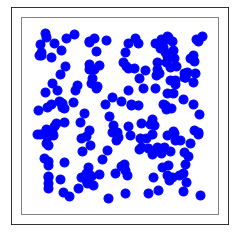

In [5]:
exc_fig = nest.PlotLayer(exc_pop, nodesize=80)

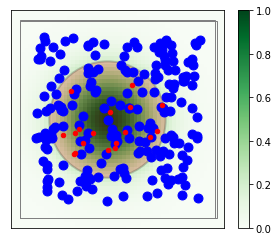

In [6]:
# exc pop (blue), inh pop (red)
if exc_circular_conn:
    exc_fig = nest.PlotLayer(exc_pop, nodesize=80)
    ctr = nest.FindCenterElement(exc_pop)
    final_fig = nest.PlotTargets(ctr, inh_pop, fig=exc_fig,
                     mask=exc_conn_dict['mask'], probability_parameter=exc_conn_dict['p'],
                     src_size=250, tgt_color='red', tgt_size=20, mask_color='red',
                     probability_cmap='Greens')

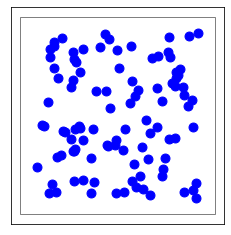

In [7]:
inh_fig = nest.PlotLayer(inh_pop, nodesize=80)

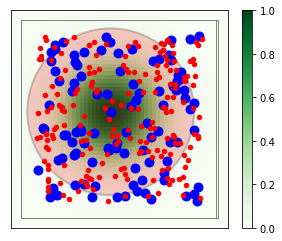

In [8]:
# inh pop (blue), exc pop (red)
if inh_circular_conn:
    inh_fig = nest.PlotLayer(inh_pop, nodesize=80)
    ctr = nest.FindCenterElement(inh_pop)
    final_fig = nest.PlotTargets(ctr, exc_pop, fig=inh_fig,
                     mask=inh_conn_dict['mask'], probability_parameter=inh_conn_dict['p'],
                     src_size=250, tgt_color='red', tgt_size=20, mask_color='red',
                     probability_cmap='Greens')

In [9]:
# recording

## voltmeter
exc_voltmeter = nest.Create("voltmeter")
inh_voltmeter = nest.Create("voltmeter")
if exc_neuron_model_name in ["edlif_psc_percent", "edlif_percent_mwe0_nestml__with_stdp0_nestml"]:
    exc_voltmeter.set({"record_from": ["V_m", "ATP", "ATP_c", "ATP_s", "E_ap_tr", "E_ap_c"]})
    exc_voltmeter.set({"record_from": ["V_m"]})
else:
    exc_voltmeter.set({"record_from": ["V_m"]})
if inh_neuron_model_name in ["edlif_psc_percent", "edlif_percent_mwe0_nestml__with_stdp0_nestml"]:
    inh_voltmeter.set({"record_from": ["V_m", "ATP", "ATP_c", "ATP_s", "E_ap_tr", "E_ap_c"]})
    inh_voltmeter.set({"record_from": ["V_m"]})
else:
    inh_voltmeter.set({"record_from": ["V_m"]})
nest.Connect(exc_voltmeter, exc_pop)
nest.Connect(inh_voltmeter, inh_pop)

## multimeter
#multimeter = nest.Create("multimeter")
#multimeter.set(record_from=["V_m"])

## spike recorder
spikerecorder = nest.Create("spike_recorder")

## weight recorder
#exc_wr = nest.Create('weight_recorder')
#nest.CopyModel(exc_synapse_model, "exc_stdp_synapse_rec", {"weight_recorder": exc_wr})
#inh_wr = nest.Create('weight_recorder')
#nest.CopyModel(inh_synapse_model, "inh_stdp_synapse_rec", {"weight_recorder": inh_wr})

## connections to devices
#nest.Connect(multimeter, exc_pop)
#nest.Connect(multimeter, inh_pop)
nest.Connect(exc_pop, spikerecorder)
nest.Connect(inh_pop, spikerecorder)


Sep 07 18:46:24 ConnectionManager [Warning]: 
    New connections created, connection descriptors previously obtained using 
    'GetConnections' are now invalid.


In [10]:
exc_inh_w_per_iter = []
for _ in range(iterations):
    nest.Simulate(simtime)
    exc_inh_conn = nest.GetConnections(exc_pop, inh_pop)
    #print(exc_inh_w)
    exc_inh_w_per_iter.append(exc_inh_conn.get("weight"))


Sep 07 18:46:24 NodeManager::prepare_nodes [Info]: 
    Preparing 307 nodes for simulation.

Sep 07 18:46:24 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 307
    Simulation time (ms): 100
    Number of OpenMP threads: 1
    Not using MPI

Sep 07 18:46:24 SimulationManager::run [Info]: 
    Simulation finished.


this is an inh neuron


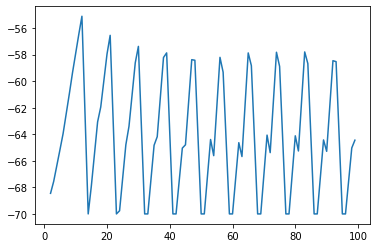

In [11]:
# Extracting voltimeter data
def get_neuron_vm(neuron_idx):
    if neuron_idx >= exc_n+inh_n:
        raise Exception(f"neuron idx should be < {exc_n+inh_n}")
    if neuron_idx >= exc_n:
        print("this is an inh neuron")
        dmm = exc_voltmeter.get()
    else:
        print("this is an exc neuron")
        dmm = inh_voltmeter.get()
    #dmm = multimeter.get()
    Vms = dmm["events"]["V_m"][neuron_idx::exc_n+inh_n]
    ts = dmm["events"]["times"][neuron_idx::exc_n+inh_n]
    return Vms, ts

neuron_idx = 200
Vms, ts = get_neuron_vm(neuron_idx)
plt.plot(ts, Vms)

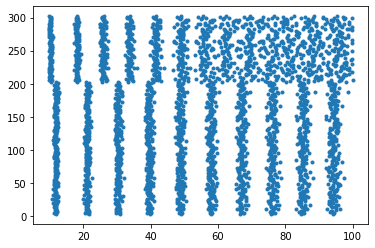

In [12]:
# extracting spikes data
dSD = spikerecorder.get("events")
evs = dSD["senders"]
ts = dSD["times"]
plt.plot(ts, evs, ".")

{'ports': array([ 354,  355,  356, ..., 2753, 2754, 2755]), 'receptors': array([0, 0, 0, ..., 0, 0, 0]), 'senders': array([ 26,  26,  26, ..., 188, 188, 188]), 'targets': array([263, 236, 272, ..., 285, 206, 246]), 'times': array([10.8, 10.8, 10.8, ..., 98.6, 98.6, 98.6]), 'weights': array([ 4.32820981,  2.3222923 ,  0.91012094, ..., 19.84041247,
       18.07347449, 19.75418701])}


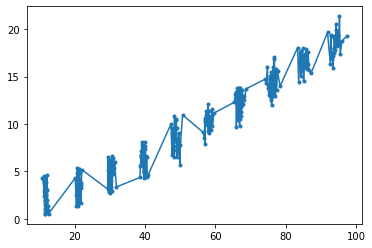

In [13]:
# extracting exc weights value data
# TODO: Fix this function! is totally wrong
def get_weight_value(pre_neuron_idx, post_neuron_idx):
    exc_inh_w  = exc_inh_wr.get("events")
    print(exc_inh_w)
    w = exc_inh_w ["weights"][pre_neuron_idx::(inh_n+1)]
    ts = exc_inh_w["times"][pre_neuron_idx::(inh_n+1)]

    return ts, w

pre_idx = 0
post_idx = 0
ts, w = get_weight_value(pre_idx, post_idx)
plt.plot(ts, w, ".-")

{'ports': array([], dtype=int64), 'receptors': array([], dtype=int64), 'senders': array([], dtype=int64), 'targets': array([], dtype=int64), 'times': array([], dtype=float64), 'weights': array([], dtype=float64)}


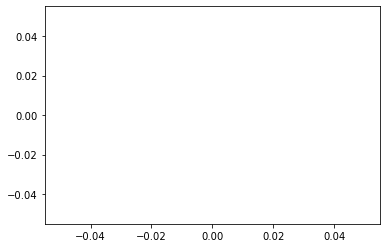

In [14]:
# extracting inh weights value data
# TODO: Fix this function! is totally wrong
def get_weight_value(pre_neuron_idx, post_neuron_idx):
    inh_exc_w = inh_exc_wr.get("events")
    print(inh_exc_w)
    w = inh_exc_w["weights"][post_neuron_idx::exc_n]
    ts = inh_exc_w["times"][post_neuron_idx::exc_n]

    return ts, w

pre_idx = 0
post_idx = 3
ts, w = get_weight_value(pre_idx, post_idx)
plt.plot(ts, w, ".-")

[[17.878185725378223, 19.473468777586394, 19.155024086818514, 18.920508941823535, 17.625726332782474, 19.438519407342266, 18.677367627436315, 17.450450005923702, 18.952267183605485, 20.957182358111893, 19.43225558641343, 17.113677305732335, 20.0327261399515, 18.57824283708592, 18.62012561480427, 17.16023524240899, 19.313641270222217, 20.22502725622309, 18.42079086364318, 19.65643785745584, 18.80044176963595, 20.399896548989567, 19.056491149436734, 19.10504352610445, 17.32708313353154, 17.904656573054503, 21.264715988558926, 19.690257758318104, 20.259743583805008, 20.54186932700538, 20.02403960032072, 19.512412604332315, 19.191091688609806, 19.554854379916826, 18.004741296818374, 18.930625700056947, 16.699588773467717, 16.59841838715307, 20.158107047712225, 17.566990960267358, 19.385637869817177, 19.77816257437978, 19.320451916137912, 19.678538887317305, 17.50905551159482, 19.347821556849258, 16.968304176326495, 19.215894546374727, 20.305239551433807, 19.837738627557677, 20.284733222901

 ...]

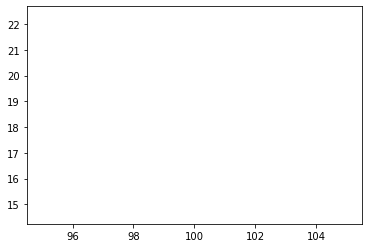

In [15]:
print(exc_inh_w_per_iter)
time = np.arange(simtime, simtime*(iterations+1), simtime)
print(time)
plt.plot(time, exc_inh_w_per_iter)

In [16]:
exc_noise

NodeCollection(metadata=None, model=poisson_generator, size=1, first=303)

In [17]:
#plt.plot(exc_noise)

In [18]:
nest.GetDefaults("stdp0_nestml__with_edlif_psc_alpha_percent0_nestml")

NESTErrors.UnknownComponent: UnknownComponent in SLI function GetDefaults_l: /stdp0_nestml__with_edlif_psc_alpha_percent0_nestml is not a known component.

In [ ]:
nest.GetDefaults("stdp_synapse")

In [ ]:
nest.GetDefaults("iaf_psc_alpha")

In [ ]:
import numpy
test = nest.Create("edlif_psc_exp_percent", 5)
print(test)
#test.set({"ATP": nest.random.normal(mean=5, std=1)})
mean = 5
std = 1
test.set({"ATP": [mean+std*numpy.random.rand() for x in range(len(test))]})
test.get("ATP")